# Perceptron Classifier Refactored

The code for the perceptron classifier as a python Class. Also the preprocessing code is refactored here.

In [1]:
#!conda install -y -c pytorch torchvision
#!conda install -y matplotlib
#!conda install -y -c conda-forge seaborn

In [2]:
# import needed libraries
import torch as pt
# We will just use this for loading
import pandas as pd
# Sometimes it is just easier to use numpy than pytorch
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

## Loading and preprocessing the data

This is a refactored version of loading the data from [palmerpenguins](https://github.com/AllisonHorst/palmerpenguins) dataset, and then limiting to two variables and two species. Here we will remove the Adelie species. The postive class will be the Chinstrap species. This allows focusing on a binary classification problem which is easier to demonstrate a basic perceptron classifier.

We also include dropping missing data rows, suffling the data and normalizing to a training test split.

In [3]:

URL = 'https://bit.ly/palmerpenguinscsv'
penguins_df = pd.read_csv(URL)
penguins_df.dropna(inplace=True)
two_var_df = penguins_df[['body_mass_g', 'bill_depth_mm', 'species']]
species = ['Adelie', 'Gentoo', 'Chinstrap']
# drop Adelie
two_var_two_class_df =  two_var_df[ two_var_df['species'] != 'Adelie']
rawX = pt.Tensor(two_var_two_class_df[['body_mass_g', 'bill_depth_mm']].values)
rawy = pt.Tensor((two_var_two_class_df['species']=='Chinstrap').values*2.0) - 1

num_rows = rawX.shape[0]
# train-valid split
ptc_train = .8
# Shuffle the indices
shuffled_inds =  pt.randperm(num_rows)

# How much for validation (20%)
pct_valid = .2

# how many train?
num_train = int(np.floor(ptc_train*num_rows))
train_rawX, train_y = rawX[shuffled_inds[:num_train],:], rawy[shuffled_inds[:num_train]]
valid_rawX, valid_y = rawX[shuffled_inds[num_train:],:], rawy[shuffled_inds[num_train:]]
train_mean = train_rawX.mean(axis=0)
train_std = train_rawX.std(axis=0)

train_X = (train_rawX-train_mean)/train_std
valid_X = (valid_rawX-train_mean)/train_std
print(f'{train_X.shape[0]} training examples and {valid_X.shape[0]} validation examples')

149 training examples and 38 validation examples


## Perceptron as a Python Class

We are trying to Perceptron as a reusable class. We are using private methods "_weight_delta" and "_update" to update weights. Instead of "fit" we are using "forward" since this tends to be the what you see when using pytorch.

In [4]:
import torch as pt

class Perceptron:
    """
    A simple implementation of a Perceptron model for binary classification.

    Parameters:
        input_size (int): The number of input features (default is 2).
        seed (int): Seed for reproducibility (default is None).
        learning_rate (float): The learning rate for weight updates (default is 0.01).
        verbose (bool): If True, prints updates during training (default is False).
    """

    def __init__(self, input_size=2, seed=None, learning_rate=0.01, verbose=False):
        self.verbose = verbose
        self.learning_rate = learning_rate
        if seed:
            pt.manual_seed(seed)
        self.input_size = input_size
        self.weights = pt.randn((1, self.input_size + 1))
        self._max_epochs = 5

    def forward(self, input_data):
        """
        Forward pass of the Perceptron.

        Parameters:
            input_data (torch.Tensor): Input data of shape (batch_size, input_size).

        Returns:
            torch.Tensor: Predicted labels (1 or -1) for each input.
        """
        assert input_data.shape[1] == self.weights.shape[1] - 1
        padded_input = pt.cat([pt.ones((input_data.shape[0], 1)), input_data], dim=1)
        z = pt.matmul(padded_input, self.weights.t())
        phi_z = pt.where(z >= 0, pt.tensor(1.0), pt.tensor(-1.0))
        return phi_z

    def _weight_delta(self, input_row, target_row):
        """
        Compute weight update for a single data point.

        Parameters:
            input_row (torch.Tensor): Input data for a single instance.
            target_row (torch.Tensor): True label for the corresponding instance.

        Returns:
            torch.Tensor or None: Weight update if needed, None otherwise.
        """
        row_predicted_target = self.forward(input_row)
        target_diff = target_row - row_predicted_target
        padded_row = pt.cat([pt.ones((input_row.shape[0], 1)), input_row], dim=1)
        if pt.abs(target_diff) > 0:
            return self.learning_rate * target_diff * padded_row
        else:
            return None

    def _update(self, input_row, target_row):
        """
        Update weights based on a single data point.

        Parameters:
            input_row (torch.Tensor): Input data for a single instance.
            target_row (torch.Tensor): True label for the corresponding instance.

        Returns:
            bool: True if an update is performed, False otherwise.
        """
        weight_delta = self._weight_delta(input_row, target_row)
        if weight_delta != None:
            self.weights += weight_delta
            return True
        return False

    def train(self, train_input, train_target, valid_input, valid_target, max_epochs=None, learning_rate=None):
        """
        Train the Perceptron model.

        Parameters:
            train_input (torch.Tensor): Training input data.
            train_target (torch.Tensor): True labels for training data.
            valid_input (torch.Tensor): Validation input data.
            valid_target (torch.Tensor): True labels for validation data.
            max_epochs (int): Maximum number of training epochs.
            learning_rate (float): Learning rate for weight updates.

        Returns:
            list, list: Lists of training and validation accuracies for each epoch.
        """
        train_acc_path = []
        valid_acc_path = []
        if max_epochs:
            self._max_epochs = max_epochs
        if learning_rate:
            self.learning_rate = learning_rate

        for epoch in range(1, self._max_epochs + 1):
            num_updates = 0
            for ind in pt.arange(train_input.shape[0]):
                input_row = train_input[ind: ind + 1, :]
                target_row = train_target[ind: ind + 1]
                is_update = self._update(input_row, target_row)
                if is_update:
                    num_updates += 1
                    if self.verbose:
                        print('u', end='')
                elif self.verbose:
                    print('.', end='')

            print(f'\nEpoch {epoch} complete')
            train_acc = self.accuracy(train_input, train_target)
            valid_acc = self.accuracy(valid_input, valid_target)
            train_acc_path.append(train_acc)
            valid_acc_path.append(valid_acc)
            print(f'train accuracy: {train_acc}')
            print(f'valid accuracy: {valid_acc}')
            print(num_updates)

            if num_updates == 0:
                if self.verbose:
                    print(f'No updates, terminating')
                break

        return (pt.Tensor(train_acc_path).tolist(),
                pt.Tensor(valid_acc_path).tolist())

    def accuracy(self, input_data, target_data):
        """
        Calculate accuracy of the model on given data.

        Parameters:
            input_data (torch.Tensor): Input data.
            target_data (torch.Tensor): True labels for input data.

        Returns:
            float: Accuracy of the model on the given data.
        """
        predicted_data = self.forward(input_data).squeeze()
        return (predicted_data == target_data).sum() / len(target_data)




### Test and visualize the perceptron

Here we run the perceptron (without training) on two penguin classes. To visualize the untrained perceptron we plot the decision boundary by noting if the the forward pass gives before the activation:

$z = w_0*1 + w_1 x + w_2 y$

then the deciion boundary is where $z=0$. Solving for y we get $y = (-1/w_2) (w_0 + w_1 x)$. In other words $y = m x + b$ where $m = -w_1/w_2$ and $b = -w_0/w_2$.


Initial train accuracy: 0.4026845693588257
Initial valid accuracy: 0.42105263471603394



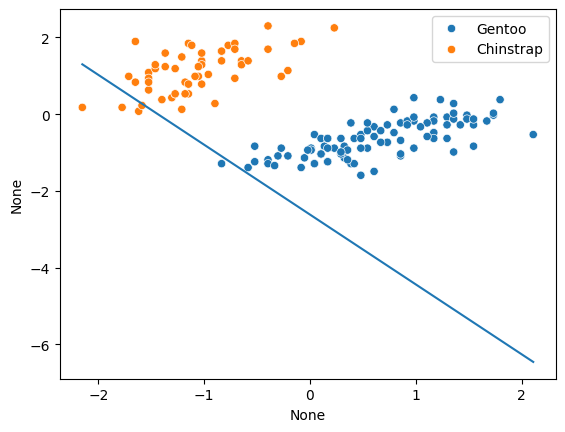

In [5]:
model = Perceptron(verbose=True, seed=42)
model.forward(train_X)

train_acc = model.accuracy(train_X, train_y)
valid_acc = model.accuracy(valid_X, valid_y)
print(f'Initial train accuracy: {train_acc}')
print(f'Initial valid accuracy: {valid_acc}\n')

minX, minY = train_X.min(axis=0)[0]
maxX, maxY = train_X.max(axis=0)[0]
minX, maxX = float(minX), float(maxX)

# Plotting the decision boundary
b = -float(model.weights[0,0])/float(model.weights[0,1])
m = -float(model.weights[0,2])/float(model.weights[0,1])

labels = np.array(['Gentoo', 'Chinstrap'])[(train_y == 1)*1]

fig, ax = plt.subplots()
_ = sns.scatterplot(x=train_X[:,0],
                y=train_X[:,1],
                hue=labels,
                ax=ax)

_ = sns.lineplot(x=[minX, maxX],
             y=[b+m*minX,b+m*maxX])

## Run the training

Here we run the training for the perceptron. As it goes, it will show updates with a "u" and no updates with a "." per instance. It also returns the sequence of training and validation accuracies for each epoch.

In [6]:
train_acc_path, valid_acc_path = model.train(train_X,
                                             train_y,
                                             valid_X,
                                             valid_y,
                                             max_epochs=6)
train_acc = model.accuracy(train_X, train_y)
valid_acc = model.accuracy(valid_X, valid_y)
print(f'\ntrained train accuracy: {train_acc}')
print(f'trained valid accuracy: {valid_acc}')

uuuuu..u..u....u.....u...uuu............u.............................................................u..............................................
Epoch 1 complete
train accuracy: 0.9798657894134521
valid accuracy: 0.9210526347160339
14
...........................u.........................................................................................................................
Epoch 2 complete
train accuracy: 0.9932885766029358
valid accuracy: 0.9473684430122375
1
...........................u.........................................................................................................................
Epoch 3 complete
train accuracy: 1.0
valid accuracy: 0.9736841917037964
1
.....................................................................................................................................................
Epoch 4 complete
train accuracy: 1.0
valid accuracy: 0.9736841917037964
0
No updates, terminating

trained train accuracy: 1.0
trained valid accura

### Reformating the training, testing data into a data frame.

It becomes easier to show the curves if we set up the plots in a data frame.

In [7]:
training_curves_df = pd.DataFrame({'steps':(np.arange(len(train_acc_path))+1),
                                   'train acc':train_acc_path,
                                   'valid acc':valid_acc_path})
training_curves_df

,steps,train acc,valid acc
0,1,0.979866,0.921053
1,2,0.993289,0.947368
2,3,1.000000,0.973684
3,4,1.000000,0.973684


### Ploting train-test curves

Plotting the training and validation curves. We plot per epoch. Note we write so that the algorithm terminates if we pass through an epoch without updating since it will not update after that.

(0.0, 1.1)

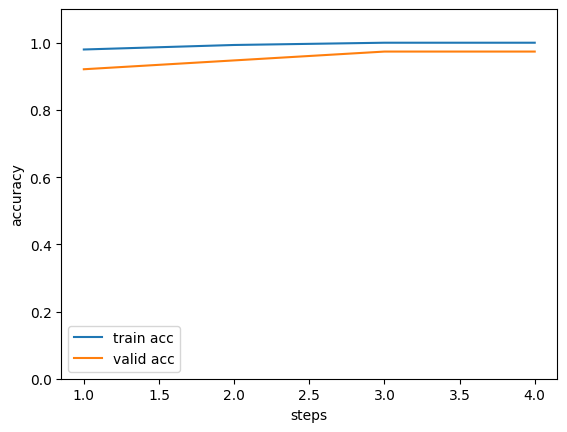

In [8]:
fig, ax = plt.subplots()
_ = sns.lineplot(data=training_curves_df,
             x='steps', y='train acc',
             label='train acc', ax=ax)
_ = sns.lineplot(data=training_curves_df,
             x='steps', y='valid acc',
             label='valid acc', ax=ax)
ax.set_ylabel('accuracy')
ax.set_ylim(0, 1.1)

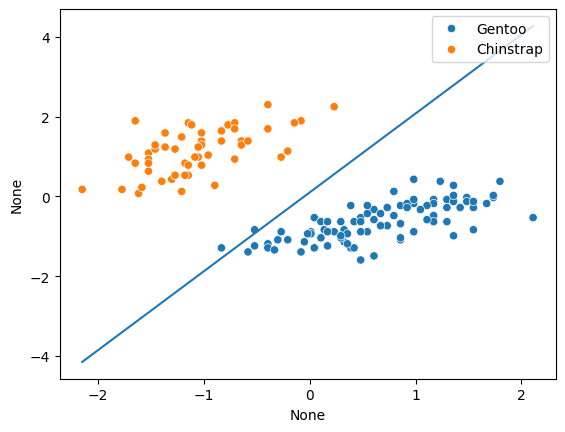

In [9]:

# Plotting the decision boundary
b = -float(model.weights[0,0])/float(model.weights[0,1])
m = -float(model.weights[0,2])/float(model.weights[0,1])

labels = np.array(['Gentoo', 'Chinstrap'])[(train_y == 1)*1]

fig, ax = plt.subplots()
_ = sns.scatterplot(x=train_X[:,0],
                y=train_X[:,1],
                hue=labels,
                ax=ax)

_ = sns.lineplot(x=[minX, maxX],
             y=[b+m*minX,b+m*maxX])

_ = sns.move_legend(ax, 'upper right')